In [1]:
import echoviz as ecv
import h5py
import numpy as np

from pathlib import Path
from scipy.ndimage import binary_fill_holes, grey_closing

from ply.voxelize import normal_extrude, region_growing_extrude, subdiv_region_growing_extrude

In [26]:
def load_inputs(path):
    pdata = path.parent.parent.joinpath(path.stem + ".h5")
    hdf = h5py.File(pdata, 'r')
    # Voxel info
    origin = hdf["VolumeGeometry"]["origin"][()]
    directions = hdf["VolumeGeometry"]["directions"][()]
    spacing = hdf["VolumeGeometry"]["resolution"][()]
    nbf = int(hdf["VolumeGeometry"]["frameNumber"][()])
    # Input frames
    inputs = []
    for i in range(nbf):
        voxels = hdf["CartesianVolume"][f"vol{i + 1:02d}"][()]
        inputs.append(ecv.VoxelGrid(voxels, origin, directions, spacing))
    voxshape = inputs[0].values.shape
    hdf.close()
    return {"nbf": nbf, "voxshape": voxshape, "inputs": inputs}

def load_annotations(pdata, nbf, voxshape, inputs): 
    labels = {"old-ant": [], "old-post": [], "new-ant": [], "new-post": []}
    thickness = 0.003
    for f, afname in zip(range(nbf), pdata.iterdir()):
        i = inputs[f]
        pfname = afname.with_stem(f"posterior-{afname.stem.split('-')[1]}")
        # Current way of doing it (extrude along normals with same thickness)
        oant = normal_extrude(afname, i.spacing, voxshape, i.origin, i.directions, extrude=thickness)
        opost = normal_extrude(pfname, i.spacing, voxshape, i.origin, i.directions, extrude=thickness)
        labels["old-ant"].append(ecv.VoxelGrid(oant, i.origin, i.directions, i.spacing))
        labels["old-post"].append(ecv.VoxelGrid(opost, i.origin, i.directions, i.spacing))
        # Select according to voxel intensity
        #nant = region_growing_extrude(afname, spacing, voxshape, origin, directions, inputs[f].values, thickness)
        #npost = region_growing_extrude(pfname, spacing, voxshape, origin, directions, inputs[f].values, thickness)
        #nlabels["anterior"].append(ecv.VoxelGrid(nant, origin, directions, spacing))
        #nlabels["posterior"].append(ecv.VoxelGrid(npost, origin, directions, spacing))
        # Select according to subdivided voxel intensity
        snant = subdiv_region_growing_extrude(afname, i.spacing, voxshape, i.origin, i.directions, i.values, thickness, 1)
        snpost = subdiv_region_growing_extrude(pfname, i.spacing, voxshape, i.origin, i.directions, i.values, thickness, 1)
        labels["new-ant"].append(ecv.VoxelGrid(snant, i.origin, i.directions, i.spacing))
        labels["new-post"].append(ecv.VoxelGrid(snpost, i.origin, i.directions, i.spacing))
    return labels

In [40]:
reviewed = "reviewed"
pdata_FMR = Path(f"~/Documents/data/test-data/{reviewed}/20150624151535_FMR").expanduser()
pdata_FED = Path(f"~/Documents/data/test-data/{reviewed}/20150825110314_FED").expanduser()
# Load inputs frames
fmr = load_inputs(pdata_FMR)
fed = load_inputs(pdata_FED)
# Load annotations
fmr.update(load_annotations(pdata_FMR, fmr["nbf"], fmr["voxshape"], fmr["inputs"]))
fed.update(load_annotations(pdata_FED, fed["nbf"], fed["voxshape"], fed["inputs"]))

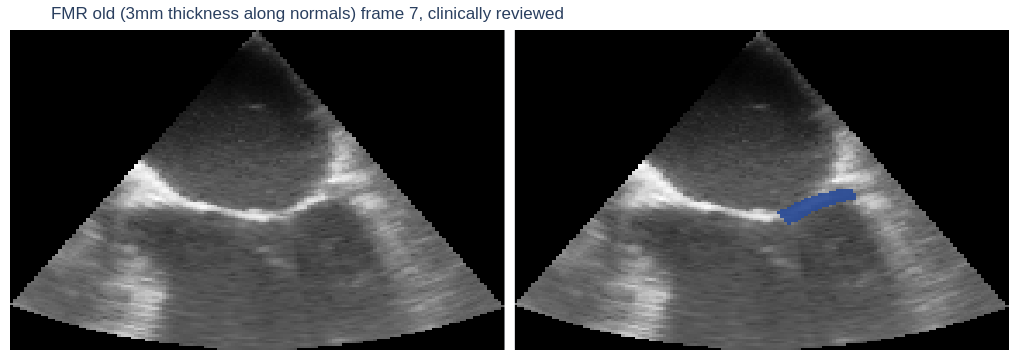

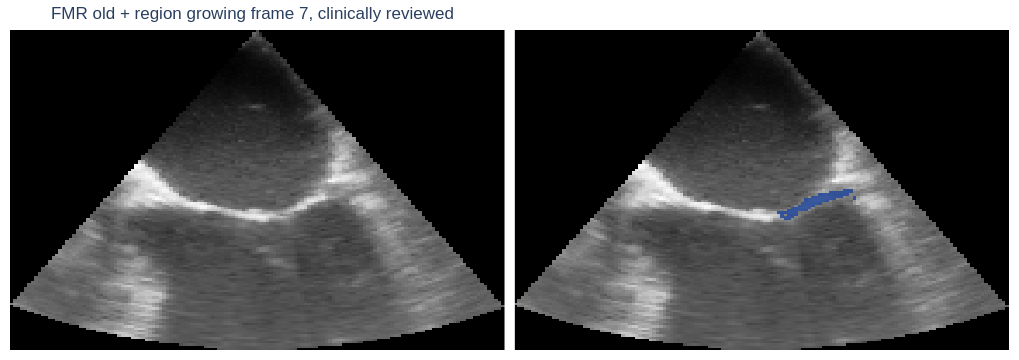

In [49]:
# Plotting
data, name = fmr, "FMR"
axis, f = 0, int(data["nbf"] / 2)

# Plot one slice (middle)
foo = ecv.plot_slice(data["inputs"][f], {"anterior": data["old-ant"][f], "posterior": data["old-post"][f]},
                     int(data["voxshape"][axis]/2), axis=axis,
                     title=f"{name} old (3mm thickness along normals) frame {f}, clinically {reviewed}")
foo = ecv.plot_slice(data["inputs"][f], {"anterior": data["new-ant"][f], "posterior": data["new-post"][f]},
                     int(data["voxshape"][axis]/2), axis=axis,
                     title=f"{name} old + region growing frame {f}, clinically {reviewed}")
# Plot full sequence
ecv.sliced_sequence(data["inputs"], {"anterior": data["old-ant"], "posterior": data["old-post"]},
                    int(data["voxshape"][axis] / 2), axis=axis,
                    title=f"{name} old (3mm thickness along normals), clinically {reviewed}",
                    filename=f"{name}_oldway_axis-{axis}_{reviewed}.gif")
ecv.sliced_sequence(data["inputs"], {"anterior": data["new-ant"], "posterior": data["new-post"]},
                    int(data["voxshape"][axis] / 2), axis=axis,
                    title=f"{name} old + region growing, clinically {reviewed}",
                    filename=f"{name}_newway_axis-{axis}_{reviewed}.gif")

In [42]:
def add_postprocess(data):
    out = {"pp-ant": [], "pp-post": []}
    for f in range(data["nbf"]):
        i = data["inputs"][f]
        ant = grey_closing(data["new-ant"][f].values, (2, 2, 2), None, None, mode="reflect", cval=0, origin=0)
        post = grey_closing(data["new-post"][f].values, (2, 2, 2), None, None, mode="reflect", cval=0, origin=0)
        #ant = binary_fill_holes(data["new-ant"][f].values, None, origin=0)
        #post = binary_fill_holes(data["new-post"][f].values, None, origin=0)
        ant = binary_fill_holes(ant, None, origin=0)
        post = binary_fill_holes(post, None, origin=0)
        out["pp-ant"].append(ecv.VoxelGrid(ant, i.origin, i.directions, i.spacing))
        out["pp-post"].append(ecv.VoxelGrid(post, i.origin, i.directions, i.spacing))
    return out

# Do some post-processing to see if it helps
fmr.update(add_postprocess(fmr)), fed.update(add_postprocess(fed))

(None, None)

In [50]:
# Plotting
data, name = fmr, "FMR"
axis = 0

ecv.sliced_sequence(data["inputs"], {"anterior": data["pp-ant"], "posterior": data["pp-post"]},
                    int(data["voxshape"][axis] / 2), axis=axis,
                    title=f"{name} old + region growing + post-processed, clinically {reviewed}",
                    filename=f"{name}_newway_axis-{axis}_{reviewed}_post-processed.gif")